In [1]:
import gymnasium as gym
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)

In [2]:
import copy
import pylab
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import argparse, pdb
import numpy as np
import os
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.distributions import Categorical

In [3]:
class A2C(nn.Module):
    def __init__(self, state_size, action_size):
        super(A2C, self).__init__()
        self.actor_fc1 = nn.Linear(state_size, 64)
        self.actor_fc2 = nn.Linear(64, 64)
        self.actor_fc_out = nn.Linear(64, action_size)

        self.critic_fc1 = nn.Linear(state_size, 64)
        self.critic_fc2 = nn.Linear(64, 64)
        self.critic_fc_out = nn.Linear(64, 1)

    def forward(self, x):
        actor_x = F.relu(self.actor_fc1(x))
        actor_x = F.relu(self.actor_fc2(actor_x))
        logits = self.actor_fc_out(actor_x)

        critic_x = F.relu(self.critic_fc1(x))
        critic_x = F.relu(self.critic_fc2(critic_x))
        value = self.critic_fc_out(critic_x)
        return logits, value

class A2CAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        # 하이퍼 파라미터
        self.discount_factor = 0.99
        self.learning_rate = 5e-4

        self.steps_done = 0

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = A2C(self.state_size, self.action_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    # Policy에 따른 action 선택
    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            logits, _ = self.model(state)
        dist = Categorical(logits=logits[0])
        action = dist.sample()

        return action.item()

    def train_model(self, state, action, reward, next_state, done):

        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        next_state = torch.tensor(next_state, dtype=torch.float32).to(self.device)
        action = torch.tensor(action, dtype=torch.long).to(self.device)
        reward = torch.tensor(reward, dtype=torch.float32).to(self.device)
        done = torch.tensor(done, dtype=torch.float32).to(self.device)

        logits, value = self.model(state)
        _, next_value = self.model(next_state)

        value = value.squeeze()
        next_value = next_value.squeeze()

        target = reward + (1-done) * self.discount_factor * next_value.detach()
        advantage = (target - value).detach()

        dist = Categorical(logits=logits[0])
        log_prob = dist.log_prob(action)

        entropy = dist.entropy()

        actor_loss = - log_prob * advantage - 0.01 * entropy
        #actor_loss *= 10
        critic_loss = F.mse_loss(target, value)
        critic_loss *= 0.1
        loss = actor_loss + critic_loss

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 50)
        self.optimizer.step()

        return actor_loss, critic_loss

In [4]:
root = os.getcwd()
save_dir = root + '\saved_models\A2C'
print(save_dir)

c:\Users\Lee\PythonWorkspace\RL\saved_models\A2C


episode:    0, score: -85.803827, actor loss: -91.665, critic loss: 997.834
episode:    1, score: -350.956748, actor loss: -53.092, critic loss: 959.996
episode:    2, score: -114.595612, actor loss: -263.747, critic loss: 973.305
episode:    3, score: -192.449213, actor loss: -64.308, critic loss: 929.027
episode:    4, score: -323.206089, actor loss: -68.793, critic loss: 649.454
episode:    5, score: -243.190594, actor loss: -69.270, critic loss: 679.259
episode:    6, score: -261.744854, actor loss: -89.799, critic loss: 350.115
episode:    7, score: -276.758292, actor loss: 21.429, critic loss: 26.878
episode:    8, score: -446.417640, actor loss: 35.351, critic loss: 367.714
episode:    9, score: -204.581481, actor loss: -24.976, critic loss: 192.345
episode:   10, score: -12.910343, actor loss: -161.614, critic loss: 340.158
episode:   11, score: -313.716800, actor loss: 119.482, critic loss: 170.594
episode:   12, score: -374.485502, actor loss: -0.073, critic loss: 0.104
episo

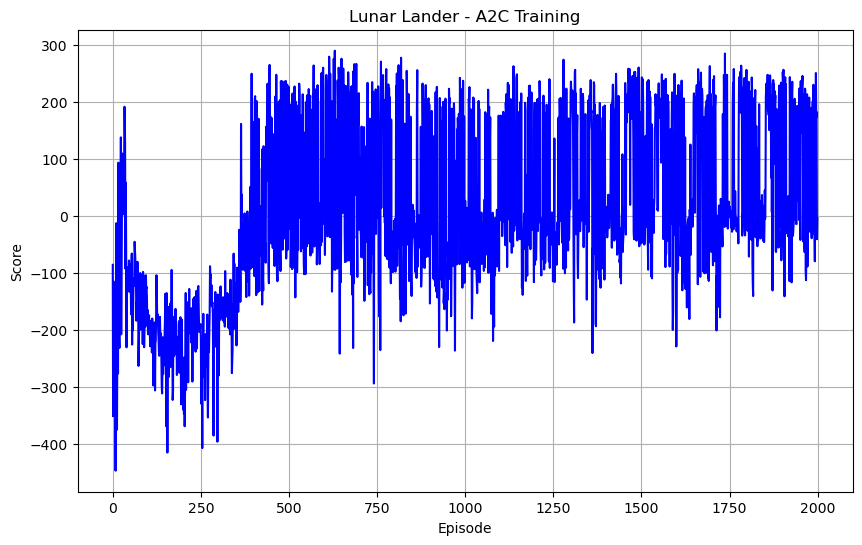

In [42]:
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = A2CAgent(state_size, action_size)

scores, episodes = [], []

EPISODES = 2000
for e in range(EPISODES):
    done = False
    score = 0
    # env 초기화
    state, info = env.reset()
    state = np.reshape(state, [1, state_size])

    while not done:
        # 현재 상태에 대한 행동 선택
        action = agent.get_action(state)

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        next_state = np.reshape(next_state, [1, state_size])

        # 샘플로 모델 학습
        actor_loss, critic_loss = agent.train_model(state, action, reward, next_state, done)
        
        score += reward
        state = next_state

        if done:
            print(f"episode: {e:4d}, score: {score:3f}, actor loss: {actor_loss:.3f}, critic loss: {critic_loss:.3f}")
            scores.append(score)
            episodes.append(e)

    # 100 에피소드마다 모델 저장
    if e > 0 and (e+1) % 100 == 0:
        file_name = f"lunar_lander_A2C_ep{e+1}.pth"
        save_path = os.path.join(save_dir, file_name)
        torch.save(agent.model.state_dict(), save_path)
        print(f"--- Model saved at {save_path} ---")

plt.figure(figsize=(10, 6))
plt.plot(episodes, scores, 'b')
plt.title("Lunar Lander - A2C Training")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.grid(True)
plt.show()

env.close()

In [ ]:
root = os.getcwd()
save_dir = os.path.join(root, "saved_models", "A2C")
os.makedirs(save_dir, exist_ok=True)

MODEL_PATH = os.path.join(save_dir, "lunar_lander_A2C_ep2000.pth")
START_EPISODE = 2000
EPISODES_TO_ADD = 1000

# 환경 및 에이전트 생성
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = A2CAgent(state_size, action_size)

if os.path.exists(MODEL_PATH):
    agent.model.load_state_dict(torch.load(MODEL_PATH))
    agent.model.train()

scores, episodes = [], []
for e in range(START_EPISODE, START_EPISODE + EPISODES_TO_ADD):
    done = False
    score = 0
    state, info = env.reset()
    state = np.reshape(state, [1, state_size])

    while not done:
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        next_state = np.reshape(next_state, [1, state_size])

        actor_loss, critic_loss = agent.train_model(state, action, reward, next_state, done)
        
        score += reward
        state = next_state
        
    scores.append(score)
    episodes.append(e)
    print(f"episode: {e:4d} | score: {score:7.2f} | actor_loss: {actor_loss:.3f} | critic_loss: {critic_loss:.3f}")

    if (e + 1) % 100 == 0:
        file_name = f"lunar_lander_A2C_ep{e+1}.pth"
        save_path = os.path.join(save_dir, file_name)
        torch.save(agent.model.state_dict(), save_path)
        print(f"--- Model saved at {save_path} ---")

env.close()

--- Loading model from c:\Users\Lee\PythonWorkspace\RL\saved_models\A2C\lunar_lander_A2C_ep2000.pth ---


C:\Users\Lee\AppData\Local\Temp\ipykernel_16156\2024517477.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.model.load_state_dict(torch.load(MODEL_PATH))


episode: 2000 | score:    0.65 | actor_loss: 0.049 | critic_loss: 20.076
episode: 2001 | score:   -8.04 | actor_loss: 3.447 | critic_loss: 19.104
episode: 2002 | score:   -6.11 | actor_loss: 2.883 | critic_loss: 36.889
episode: 2003 | score:    9.32 | actor_loss: 0.120 | critic_loss: 20.468
episode: 2004 | score:  -17.08 | actor_loss: 0.205 | critic_loss: 20.648
episode: 2005 | score:  -11.11 | actor_loss: -0.000 | critic_loss: 21.599
episode: 2006 | score:  -33.32 | actor_loss: 0.968 | critic_loss: 33.897
episode: 2007 | score:  -23.26 | actor_loss: 0.631 | critic_loss: 0.702
episode: 2008 | score:    5.43 | actor_loss: 2.349 | critic_loss: 8.021
episode: 2009 | score:   -4.32 | actor_loss: 0.026 | critic_loss: 15.341
episode: 2010 | score:  165.32 | actor_loss: -0.000 | critic_loss: 382.045
episode: 2011 | score:    4.24 | actor_loss: 1.806 | critic_loss: 16.428
episode: 2012 | score:  203.07 | actor_loss: -0.000 | critic_loss: 419.101
episode: 2013 | score:  200.28 | actor_loss: -0.

In [5]:
MODEL_PATH = save_dir + "\lunar_lander_A2C_ep3000.pth"

episodes_n = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode="human")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

model = A2C(state_size, action_size).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

for e in range(episodes_n):
    state, info = env.reset()
    state = np.reshape(state, [1, state_size])

    done = False
    score = 0

    while not done:
        state_tensor = torch.FloatTensor(state).to(device)
        
        with torch.no_grad():
            logits, _ = model(state_tensor)
            action = torch.argmax(F.softmax(logits, dim=1)).item()
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        score += reward
        state = np.reshape(next_state, [1, state_size])

    print(f"Episode {e+1}: Score = {score:.2f}")

env.close()

C:\Users\Lee\AppData\Local\Temp\ipykernel_18608\3591270553.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


Episode 1: Score = 253.97
Episode 2: Score = 257.42
Episode 3: Score = 134.79


Episode:    0, Score: -219.16
Episode:    1, Score: -172.65
Episode:    2, Score: -68.03
Episode:    3, Score: -425.68
Episode:    4, Score: -119.06
Episode:    5, Score: -321.68
Episode:    6, Score: -102.74
Episode:    7, Score: -131.71
Episode:    8, Score: 2.11
Episode:    9, Score: -70.41
Episode:   10, Score: -107.80
Episode:   11, Score: -118.31
Episode:   12, Score: -54.69
Episode:   13, Score: -281.74
Episode:   14, Score: -81.92
Episode:   15, Score: -144.09
Episode:   16, Score: -163.35
Episode:   17, Score: -185.46
Episode:   18, Score: -349.05
Episode:   19, Score: -99.16
Episode:   20, Score: -283.17
Episode:   21, Score: -338.04
Episode:   22, Score: -222.64
Episode:   23, Score: -97.58
Episode:   24, Score: -394.89
Episode:   25, Score: -227.70
Episode:   26, Score: -30.43
Episode:   27, Score: -243.27
Episode:   28, Score: -227.23
Episode:   29, Score: -90.93
Episode:   30, Score: -80.28
Episode:   31, Score: -412.33
Episode:   32, Score: -107.79
Episode:   33, Score: 

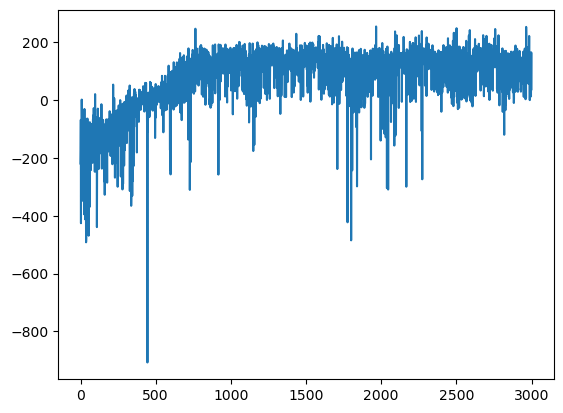

In [ ]:
import os
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Categorical
root = os.getcwd()
save_dir = os.path.join(root, "saved_models", "PPO")
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        self.actor_fc1 = nn.Linear(state_size, 64)
        self.actor_fc2 = nn.Linear(64, 64)
        self.actor_fc_out = nn.Linear(64, action_size)
        self.critic_fc1 = nn.Linear(state_size, 64)
        self.critic_fc2 = nn.Linear(64, 64)
        self.critic_fc_out = nn.Linear(64, 1)

    def forward(self, x):
        actor_x = F.relu(self.actor_fc1(x))
        actor_x = F.relu(self.actor_fc2(actor_x))
        logits = self.actor_fc_out(actor_x)
        
        critic_x = F.relu(self.critic_fc1(x))
        critic_x = F.relu(self.critic_fc2(critic_x))
        value = self.critic_fc_out(critic_x)
        return logits, value

class PPOAgent:
    def __init__(self, state_size, action_size, lr, gamma, K_epochs, eps_clip):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.lr = lr
        self.gamma = gamma
        self.K_epochs = K_epochs
        self.eps_clip = eps_clip
        
        self.memory = []

        self.policy = ActorCritic(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        self.policy_old = ActorCritic(state_size, action_size).to(self.device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.loss_fn = nn.MSELoss()

    def get_action(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).reshape(1, -1).to(self.device)
            logits, _ = self.policy_old(state)
            dist = Categorical(logits=logits)
            action = dist.sample()
            log_prob = dist.log_prob(action)
        return action.item(), log_prob.item()

    def store_transition(self, state, action, log_prob, reward, done):
        self.memory.append((state, action, log_prob, reward, done))

    def update(self):
        rewards = []
        discounted_reward = 0
        for state, action, log_prob, reward, done in reversed(self.memory):
            if done:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        old_states = torch.FloatTensor(np.array([s for s,a,lp,r,d in self.memory])).to(self.device)
        old_actions = torch.LongTensor([a for s,a,lp,r,d in self.memory]).to(self.device)
        old_log_probs = torch.FloatTensor([lp for s,a,lp,r,d in self.memory]).to(self.device)

        # K_epochs 만큼 학습 진행
        for _ in range(self.K_epochs):
            # 새로운 정책으로 값 평가
            logits, state_values = self.policy(old_states)
            dist = Categorical(logits=logits)
            
            # 어드밴티지 계산
            advantages = rewards - state_values.detach().squeeze()

            # 비율(ratio) 계산
            new_log_probs = dist.log_prob(old_actions)
            ratios = torch.exp(new_log_probs - old_log_probs.detach())
            
            # Actor 손실 (Clipped Surrogate Objective)
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            
            # Critic 손실 + 엔트로피 보너스
            critic_loss = self.loss_fn(state_values.squeeze(), rewards)
            entropy = dist.entropy().mean()
            
            loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
        # 업데이트 후, 이전 정책을 새로운 정책으로 업데이트
        self.policy_old.load_state_dict(self.policy.state_dict())
        # 메모리 비우기
        self.memory = []

if __name__ == "__main__":
    env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    
    # 하이퍼파라미터
    LEARNING_RATE = 0.002
    GAMMA = 0.99
    K_EPOCHS = 4
    EPS_CLIP = 0.2
    UPDATE_TIMESTEP = 2000 # 2000 스텝마다 업데이트
    
    agent = PPOAgent(state_size, action_size, LEARNING_RATE, GAMMA, K_EPOCHS, EPS_CLIP)
    
    scores, episodes = [], []
    timestep = 0

    EPISODES = 3000
    for e in range(EPISODES):
        state, _ = env.reset()
        score = 0
        done = False
        
        while not done:
            timestep += 1
            action, log_prob = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # 메모리에 저장
            agent.store_transition(state, action, log_prob, reward, done)
            
            state = next_state
            score += reward
            
            # 일정 스텝마다 업데이트
            if timestep % UPDATE_TIMESTEP == 0:
                agent.update()

        scores.append(score)
        episodes.append(e)
        print(f"Episode: {e:4d}, Score: {score:.2f}")

        # 모델 저장 (100 에피소드마다)
        if (e + 1) % 100 == 0:
            file_name = f"lunar_lander_PPO_ep{e+1}.pth"
            save_path = os.path.join(save_dir, file_name)
            torch.save(agent.policy.state_dict(), save_path)
            print(f"--- Model saved at {save_path} ---")

        
    plt.plot(episodes, scores)
    plt.show()
    env.close()

In [11]:
MODEL_PATH = save_dir + "\lunar_lander_PPO_ep2500.pth"

episodes_n = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode="human")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

model = ActorCritic(state_size, action_size).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

for e in range(episodes_n):
    state, info = env.reset()
    state = np.reshape(state, [1, state_size])

    done = False
    score = 0

    while not done:
        state_tensor = torch.FloatTensor(state).to(device)
        
        with torch.no_grad():
            logits, _ = model(state_tensor)
            action = torch.argmax(F.softmax(logits, dim=1)).item()
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        score += reward
        state = np.reshape(next_state, [1, state_size])

    print(f"Episode {e+1}: Score = {score:.2f}")

env.close()

C:\Users\Lee\AppData\Local\Temp\ipykernel_10000\537632870.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


Episode 1: Score = 273.36
Episode 2: Score = 34.11
Episode 3: Score = 174.03
